## Step 1: Import Libraries
First, install and import the necessary libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Step 2: Data Loading and Initial Exploration
Loading the dataset and checking its structure:

In [3]:
data = pd.read_csv("/content/online_retail.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 3. Data Cleaning
Handling Missing Values: The CustomerID column contains significant missing data, which is critical for our segmentation. Rows with missing CustomerID are removed to ensure accuracy in segmentation.

In [25]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [4]:
data_cleaned = data.dropna(subset=["CustomerID"])

Handling Negative Values: Negative values in Quantity and UnitPrice indicate product returns or refunds. We remove such transactions from the analysis to focus on actual sales.

In [5]:
data_cleaned = data_cleaned[(data_cleaned['Quantity'] > 0) & (data_cleaned['UnitPrice'] > 0)]

## 4. Exploratory Data Analysis (EDA)
### 4.1 Sales Trends
Monthly Sales: Analyzing sales over time to identify peak sales periods.

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
TotalPrice            float64
dtype: object
InvoiceDate    0
Quantity       0
dtype: int64


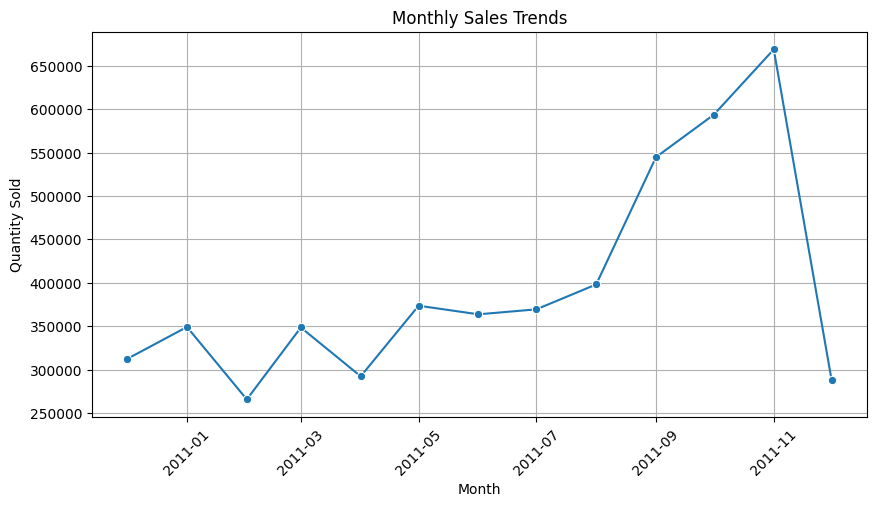

In [24]:
print(data_cleaned.dtypes)

# Check if InvoiceDate is in datetime format
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'], errors='coerce')

# Check for numeric Quantity
data_cleaned['Quantity'] = pd.to_numeric(data_cleaned['Quantity'], errors='coerce')

# Verify no NaT or NaN values in InvoiceDate and Quantity
print(data_cleaned[['InvoiceDate', 'Quantity']].isnull().sum())

# Remove rows where InvoiceDate or Quantity is NaN
data_cleaned = data_cleaned.dropna(subset=['InvoiceDate', 'Quantity'])
monthly_sales = data_cleaned.groupby(data_cleaned['InvoiceDate'].dt.to_period('M')).agg({'InvoiceNo':'nunique', 'Quantity':'sum'}).reset_index()

monthly_sales['InvoiceDate'] = monthly_sales['InvoiceDate'].dt.to_timestamp()
plt.figure(figsize=(10,5))
sns.lineplot(x='InvoiceDate', y='Quantity', data=monthly_sales, marker="o")
plt.title("Monthly Sales Trends")
plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


* :Top-Selling Products: Identifying which products generate the most revenue or
are sold in the highest quantity.

In [7]:
top_products = data_cleaned.groupby('Description').agg({'Quantity':'sum', 'UnitPrice':'mean'}).sort_values(by='Quantity', ascending=False).head(10)

<ipython-input-16-e01fd7e57b64>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_products.index, x=top_products['Quantity'], palette="viridis")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When group

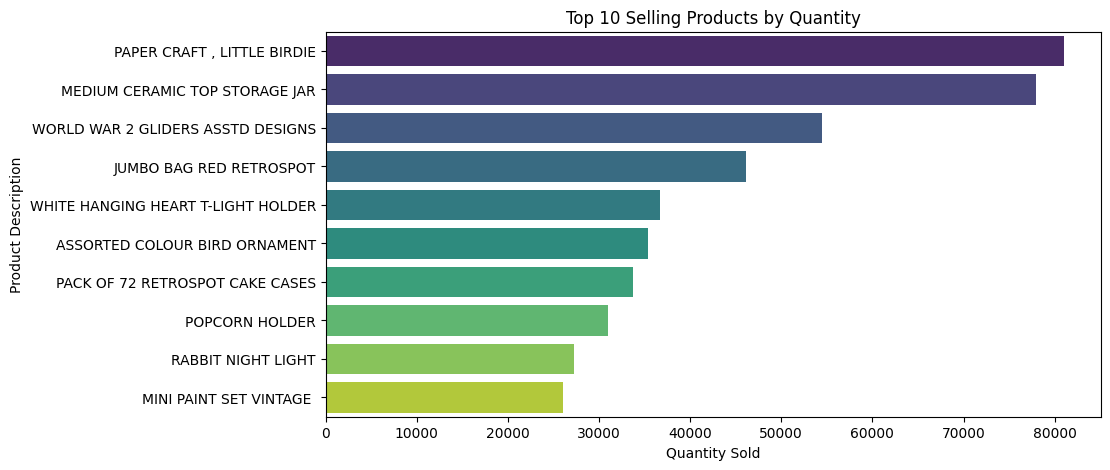

In [16]:
# Plotting Top-Selling Products
plt.figure(figsize=(10,5))
sns.barplot(y=top_products.index, x=top_products['Quantity'], palette="viridis")
plt.title("Top 10 Selling Products by Quantity")
plt.xlabel("Quantity Sold")
plt.ylabel("Product Description")
plt.show()

### 4.2 Customer Behavior
Customer Lifetime Value (CLV): Estimating how much a customer is worth based on their purchase history.

In [8]:
data_cleaned['TotalPrice'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']
clv = data_cleaned.groupby('CustomerID').agg({'TotalPrice': 'sum', 'InvoiceNo': 'nunique'})

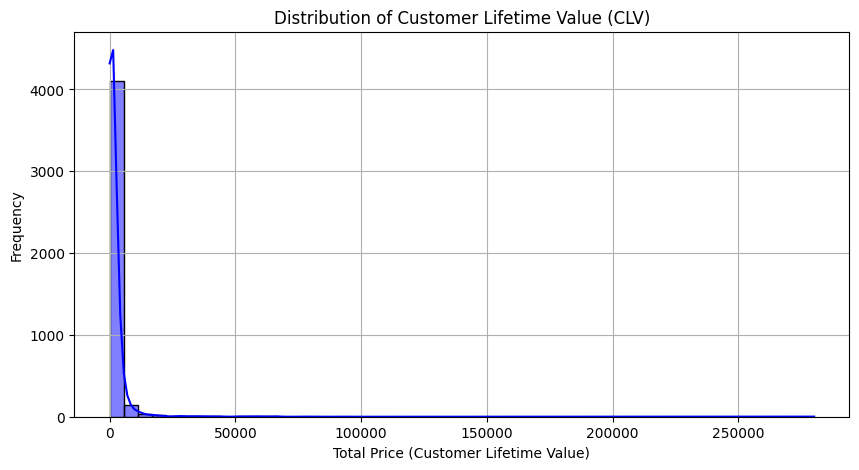

In [17]:
# Plotting Distribution of Customer Lifetime Value
plt.figure(figsize=(10,5))
sns.histplot(clv['TotalPrice'], bins=50, color="blue", kde=True)
plt.title("Distribution of Customer Lifetime Value (CLV)")
plt.xlabel("Total Price (Customer Lifetime Value)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## 5. Customer Segmentation Using RFM Analysis
The Recency, Frequency, and Monetary (RFM) model helps segment customers based on:

* Recency: How recently a customer made a purchase.
* Frequency: How often a customer makes a purchase.
* Monetary: How much a customer spends.

In [9]:
rfm = data_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (data_cleaned['InvoiceDate'].max() - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

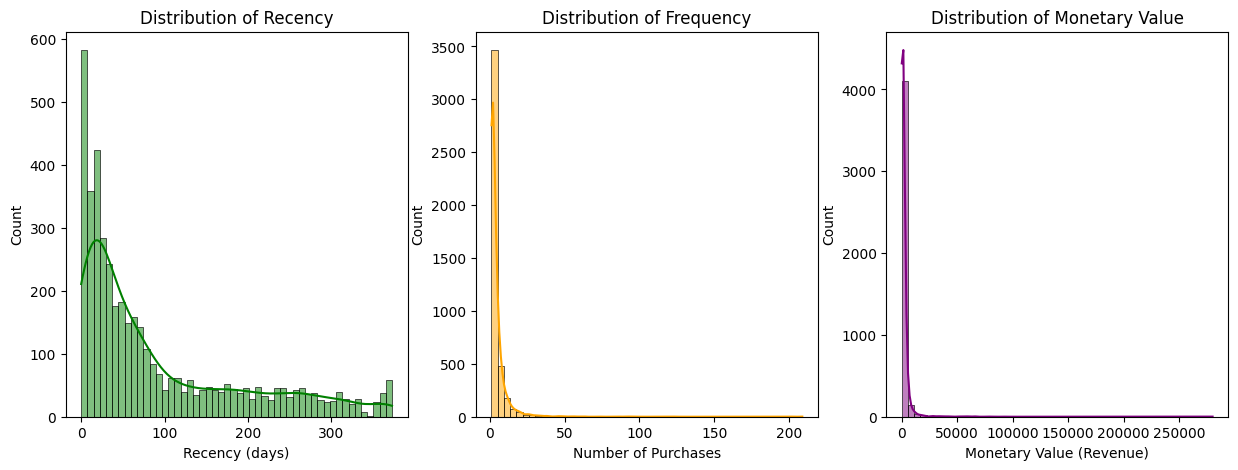

In [18]:
# Plotting RFM Distributions
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=50, kde=True, color='green')
plt.title('Distribution of Recency')
plt.xlabel('Recency (days)')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=50, kde=True, color='orange')
plt.title('Distribution of Frequency')
plt.xlabel('Number of Purchases')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=50, kde=True, color='purple')
plt.title('Distribution of Monetary Value')
plt.xlabel('Monetary Value (Revenue)')
plt.show()

## 6. Customer Segmentation Using K-Means Clustering
### 6.1 Preparing Data for Clustering
Scaling the RFM values to standardize the data:

In [10]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

### 6.2 Choosing Optimal Number of Clusters
Using the Elbow Method and Silhouette Scores to find the optimal number of clusters for customer segmentation.

In [11]:
wcss = []
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

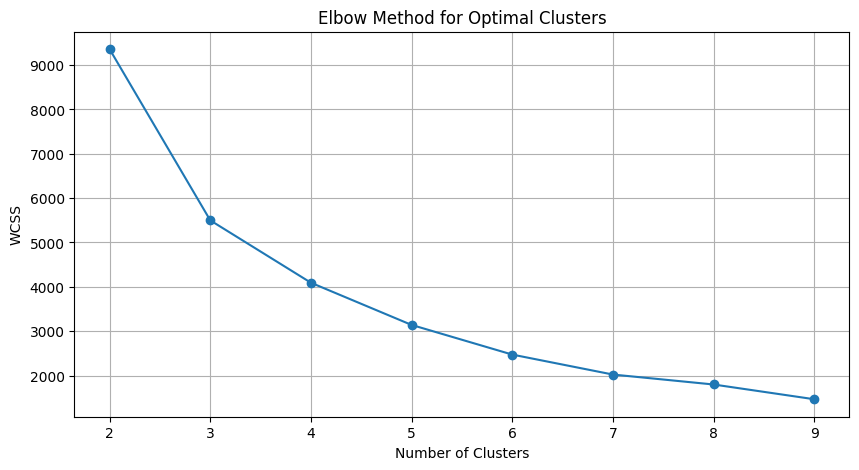

In [19]:
# Plotting WCSS (Elbow Method)
plt.figure(figsize=(10,5))
plt.plot(range(2, 10), wcss, marker="o")
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

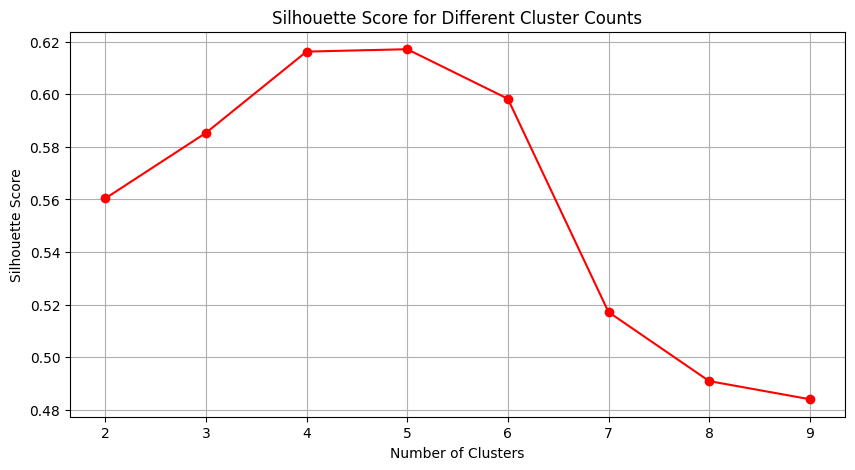

In [20]:
# Plotting Silhouette Scores
plt.figure(figsize=(10,5))
plt.plot(range(2, 10), silhouette_scores, marker="o", color="red")
plt.title("Silhouette Score for Different Cluster Counts")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

* Plotting WCSS and Silhouette Score to determine the best k.
### 6.3 Applying K-Means Clustering

In [12]:
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

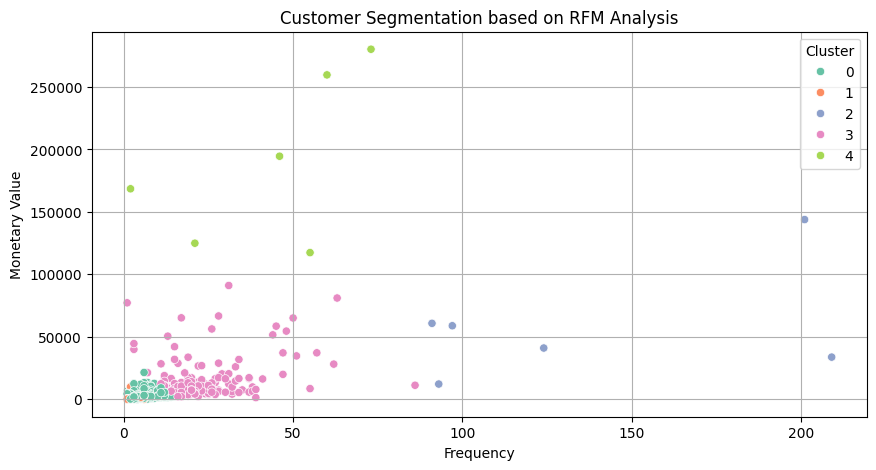

In [21]:
# Plotting Cluster Analysis
plt.figure(figsize=(10,5))
sns.scatterplot(x=rfm['Frequency'], y=rfm['Monetary'], hue=rfm['Cluster'], palette="Set2")
plt.title("Customer Segmentation based on RFM Analysis")
plt.xlabel("Frequency")
plt.ylabel("Monetary Value")
plt.grid(True)
plt.show()

## 7. Insights and Recommendations
- High-Value Customers: Target customers in the top RFM clusters for loyalty programs and personalized marketing campaigns.
- Low-Value Customers: Consider strategies for re-engaging inactive customers through targeted promotions or discounts.
- Sales Trends: Focus marketing efforts around the months or days when sales peak to maximize revenue.


## 8. Conclusion

This project showcases how exploratory data analysis and customer segmentation can help businesses better understand their customers.
By implementing an RFM model and clustering techniques, we can effectively categorize customers and tailor marketing strategies accordingly.
Future work could include applying machine learning models for predicting customer churn or optimizing sales strategies based on customer segments.
